# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy

class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

# Rescale parameters
#found_parameters = list(found_parameters)
#found_parameters[0] = found_parameters[0] / 50
#found_parameters[1] = found_parameters[1] * 500

# Show score of true solution
#print('Score at true solution: ')
#print(score(true_parameters))

# Compare parameters with original
#print('Found solution:          True parameters:' )
#for k, x in enumerate(found_parameters):
    #print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))
    
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]
start_parameters = [0.75, 1.0]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 0.05 * range_values
print("The noise is:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)
values = org_values + np.random.normal(0, noise, org_values.shape)

The noise is: 24.898095903089327


Using matplotlib, I look at the noisy time series I just simulated:

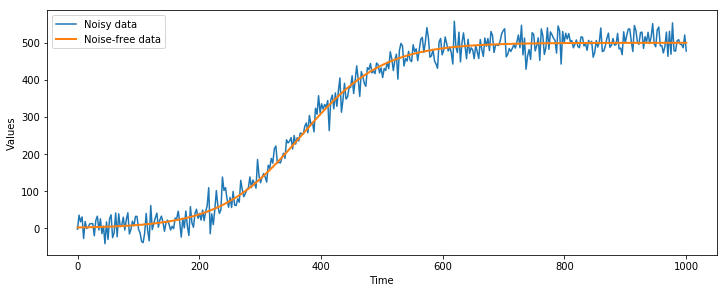

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
model = RescaledModel()
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
#bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
bounds = pints.RectangularBoundaries([0.7, 0.95], [0.8, 1.05])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

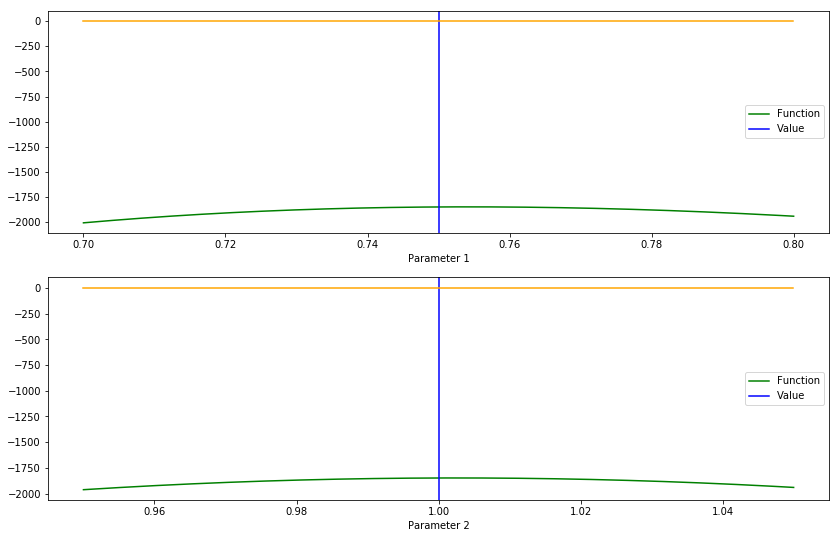

In [15]:
import numpy as np
import math

lower=[0.7, 0.95]
upper=[0.8, 1.05]
evaluations=1000
n_param = 2
f = log_likelihood
g = log_prior
x = start_parameters

# Create points to plot
xs = np.tile(x, (n_param * evaluations, 1))
for j in range(n_param):
    i1 = j * evaluations
    i2 = i1 + evaluations
    xs[i1:i2, j] = np.linspace(lower[j], upper[j], evaluations)

# Evaluate points
fs = pints.evaluate(f, xs, parallel=False)
#fs = [math.exp(f)*100 for f in fs]
gs = pints.evaluate(g, xs, parallel=False)

# Create figure
fig, axes = plt.subplots(n_param, 1, figsize=(6, 2 * n_param))
for j, p in enumerate(x):
    i1 = j * evaluations
    i2 = i1 + evaluations
    axes[j].plot(xs[i1:i2, j], fs[i1:i2], c='green', label='Function')
    axes[j].axvline(p, c='blue', label='Value')
    axes[j].set_xlabel('Parameter ' + str(1 + j))
    axes[j].legend()
    
for j, p in enumerate(x):
    i1 = j * evaluations
    i2 = i1 + evaluations
    axes[j].plot(xs[i1:i2, j], gs[i1:i2], c='orange', label='Function')
        
# Customise the figure size
fig.set_size_inches(14, 9)
plt.show()

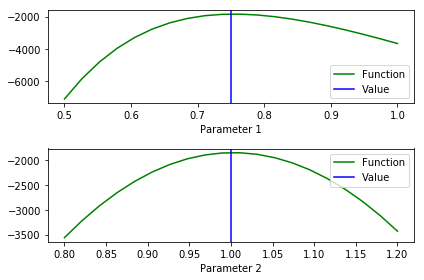

In [13]:
fig, ax = pints.plot.function(log_likelihood, start_parameters, lower=[0.5, 0.8], upper=[1.0, 1.2])

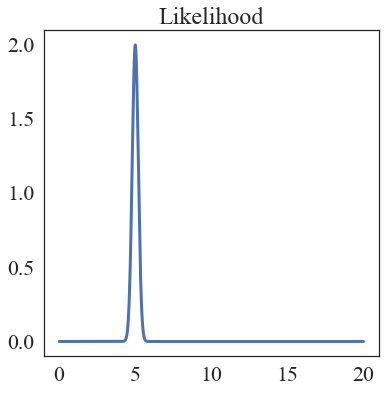

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
sns.set(context='notebook', style='white', palette='deep', font='Times New Roman', 
        font_scale=2, color_codes=True, rc={"grid.linewidth": 1})

# Plot between 0 and 20 with .001 steps.
x_axis = np.arange(0, 20, 0.001)
# Mean = 5, SD = 0.2
fig, ax = plt.subplots(figsize=(6,6))
plt.title("Likelihood")
plt.plot(x_axis, norm.pdf(x_axis,5,.2), lw=3)
plt.show()

fig.savefig("figures/integral/likelihood.png", bbox_inches='tight', dpi=200)

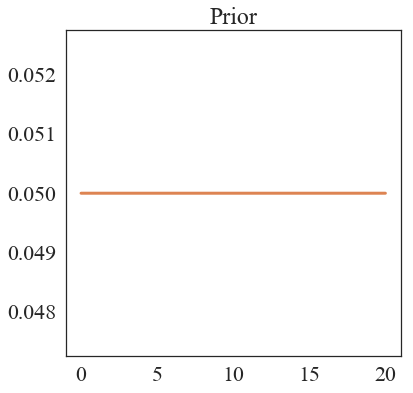

In [107]:
from scipy.stats import uniform
# Plot between 0 and 20 with .001 steps.
x_axis = np.arange(0, 20, 0.001)
fig, ax = plt.subplots(figsize=(6,6))
plt.title("Prior")
plt.plot(x_axis, uniform(scale=20).pdf(x_axis), "C1", lw=3)
plt.show()

fig.savefig("figures/integral/prior.png", bbox_inches='tight', dpi=200)

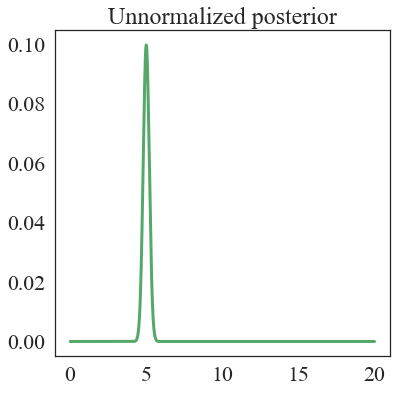

In [108]:
likelihood = norm.pdf(x_axis,5,.2)
product = [l*0.05 for l in likelihood]
# Plot between 0 and 20 with .001 steps.
x_axis = np.arange(0, 20, 0.001)
# Mean = 5, SD = 0.2
#plt.plot(x_axis, likelihood, label="Likelihood")
fig, ax = plt.subplots(figsize=(6,6))
plt.title("Unnormalized posterior")
plt.plot(x_axis, product, "C2", lw=3, label="Likelihood*Prior")
#plt.legend()
plt.show()

fig.savefig("figures/integral/posterior.png", bbox_inches='tight', dpi=200)